# Gender Image Classification 

## Data Loading

In [ ]:
# Exporting Dataset Via Kaggle

!kaggle datasets download -d cashutosh/gender-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset
License(s): other
100%|█████████████████████████████████████████| 269M/269M [04:33<00:00, 715kB/s]
100%|████████████████████████████████████████| 269M/269M [04:33<00:00, 1.03MB/s]


In [2]:
# Exporting dataset from zipfile

import zipfile
zip_ref = zipfile.ZipFile('/home/bhxveshhh/DeepLearning/Gender Classification/gender-classification-dataset.zip', 'r')
zip_ref.extractall('/home/bhxveshhh/DeepLearning/Gender Classification')
zip_ref.close()

## Data Preparation

In [ ]:
# Importing Necessory Libraries

import os
import time
import shutil
import pathlib
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

In [28]:
# Creating Dataframe

def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


# Split dataframe to train, valid, and test

def split_data(data_dir):

    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [29]:
# Loading dataset

data_dir = '/home/bhxveshhh/DeepLearning/Gender Classification/gender_df'

In [30]:
# Spliting data into train, test and validation dataframe

train_df, valid_df, test_df = split_data(data_dir)

In [ ]:
# Data Augmentation

def scalar(img):
    return img / 255.0

def create_gens(train_df, valid_df, test_df, batch_size):

    img_size = (224, 224)
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)


    ts_length = len(test_df)
    test_batch_size = max(
        sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

    test_steps = ts_length // test_batch_size

    tr_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        horizontal_flip=True,
        rotation_range=20,
        zoom_range=0.2,
        brightness_range=[0.8, 1.2],
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
    )


    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    # Train Generator
    train_gen = tr_gen.flow_from_dataframe(
        train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=batch_size
    )

    # Validation Generator
    valid_gen = ts_gen.flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=batch_size
    )

    # Test Generator
    test_gen = ts_gen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=False,
        batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


batch_size = 20
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)



Found 37606 validated image filenames belonging to 2 classes.
Found 4701 validated image filenames belonging to 2 classes.
Found 4702 validated image filenames belonging to 2 classes.


In [32]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    plt.figure(figsize=(20, 20))

    sample = min(len(labels), 25)

    for i in range(sample):
        plt.subplot(5, 5, i + 1)

        image = images[i]
        if image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))

        plt.imshow(image)

        index = np.argmax(labels[i]) if len(labels[i]) > 1 else int(labels[i])
        plt.title(classes[index], color='black', fontsize=12)
        plt.axis('off')

    plt.show()

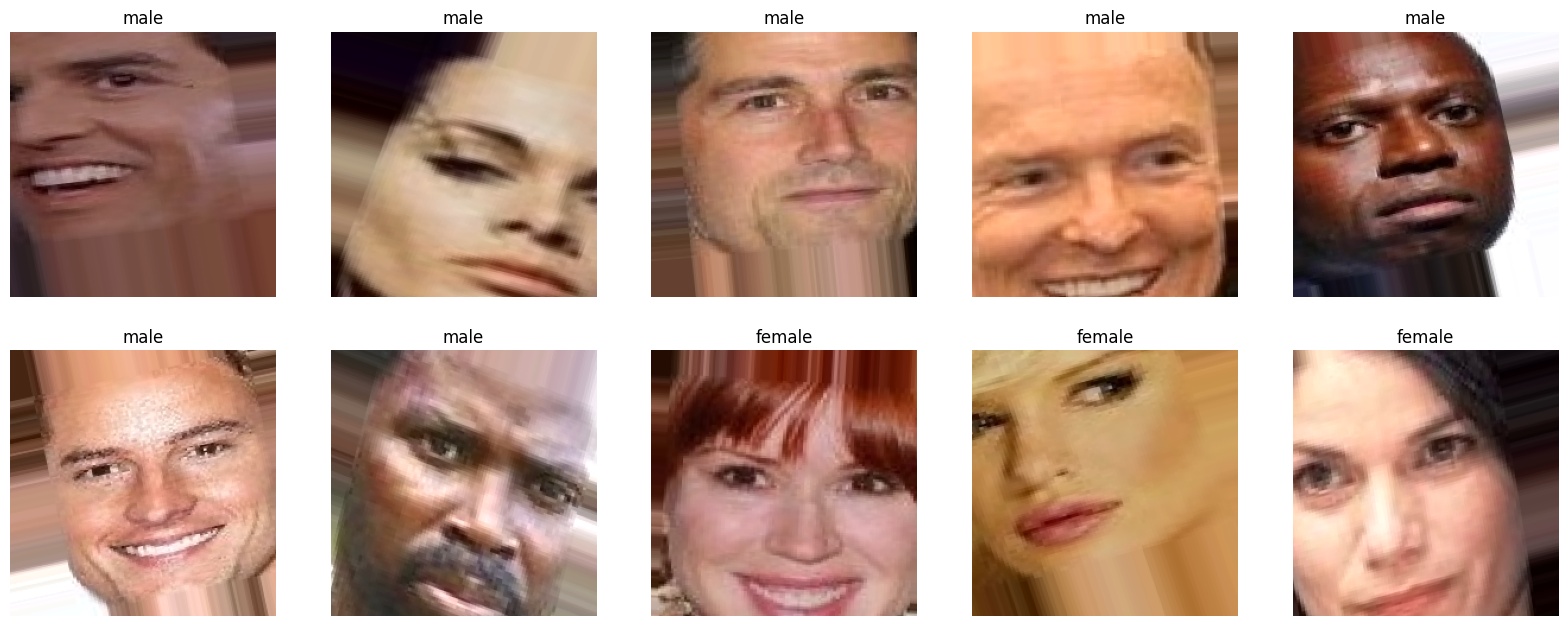

In [26]:
show_images(train_gen)

In [ ]:
model = Sequential([
    Input(shape=(224, 224, 3)), 
    Conv2D(32, 3, activation="relu"),
    MaxPooling2D(),
    Conv2D(64, 3, activation="relu"),
    MaxPooling2D(),
    Conv2D(128, 3, activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(2, activation="softmax")
])

In [ ]:
model.compile(loss= CategoricalCrossentropy(),
             optimizer = Adam(learning_rate=0.01),
             metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
history = model.fit(x= train_gen,
                    epochs= 10,
                    verbose= 1,
                    validation_data= valid_gen,
                    validation_steps= None,
                    shuffle= False)

## Model Evaluation

In [ ]:
## Model Evaluation

history_df = pd.DataFrame(history.history)


In [ ]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()